# Breast Cancer Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Analyzing the underlying structure of the data](#Principal-Component-Analysis)
5. [Final Evaluation](#Evaluating-Synthetic-Data)

In [1]:
import sys
import os

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import torchmetrics

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
project_path = os.path.abspath("..")

if project_path not in sys.path:
    sys.path.append(project_path)

import utils

## Breast Cancer Data

In [3]:
X, y = load_breast_cancer()['data'], load_breast_cancer()['target']
features, classes = load_breast_cancer()['feature_names'], np.sort(load_breast_cancer()['target_names'])

real_bc = pd.DataFrame(X, columns = features)
real_bc['target'] = y
real_bc['target'] = real_bc['target'].map({i: classes[i] for i in range(len(classes))})
print(f'{real_bc.shape[0]} row x {real_bc.shape[1]} columns = {real_bc.shape[0] * real_bc.shape[1]} values')
real_bc.head()

569 row x 31 columns = 17639 values


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,benign
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,benign
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,benign
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,benign
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,benign


The dataset contains 30 features derived from analysis of digitized images of fine-needle aspirates of breast nodules. Each feature represents a measure of the properties of the tumor cell nucleus.

The features are divided into three categories for each of the 10 core properties of the nucleus:
1. **Radius (`radius_mean`, `radius_se`, `radius_worst`)** - Mean, standard deviation and worst-case value of the average distance from the center to the points on the core perimeter.  
2. **Texture (`texture_mean`, `texture_se`, `texture_worst`)** - Variation of intensity in adjacent pixels.  
3. **Perimeter (`perimeter_mean`, `perimeter_se`, `perimeter_worst`)** - Total length of the core contour.  
4. **Area (`area_mean`, `area_se`, `area_worst`)** - Area occupied by the cell nucleus.  
5. **Complexity (`smoothness_mean`, `smoothness_se`, `smoothness_worst`)** - Uniformity of the contours of the nucleus.  
6. **Compactness (`compactness_mean`, `compactness_if`, `compactness_worst`)** - Relationship between area and perimeter of the core.  
7. **Concavity (`concavity_mean`, `concavity_se`, `concavity_worst`)** - Gravity of indentations along the perimeter of the core.  
8. **Number of concavities (`concave points_mean`, `concave points_se`, `concave points_worst`)** - Number of concave points along the core boundary.  
9. **Symmetry (`symmetry_mean`, `symmetry_se`, `symmetry_worst`)** - Similarity between the two halves of the core.  
10. **Fractal Dimension (`fractal_dimension_mean`, `fractal_dimension_se`, `fractal_dimension_worst`)** - Measure of the complexity of the shape of the core based on the fractal dimension.

357 instances are classified as **benign** and 212 as **malignant**.

Before starting modulation we will scale the data between **`[-1, 1]`** in order to use the **Tanh** function in the Generator.

In [4]:
BS = 64

X = real_bc.select_dtypes('number')

min_max = MinMaxScaler(feature_range = (-1, 1))
X_scld = min_max.fit_transform(X)

class_counts = real_bc['target'].value_counts()
class_weights = 1.0 / class_counts
sample_weights = real_bc['target'].map(class_weights)

class BreastCancer(Dataset):
    def __init__(self, data, target):
        self.data = torch.tensor(data, dtype = torch.float32)
        self.label = torch.tensor(target, dtype = torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]
    
real_bc_dataset = BreastCancer(X_scld, y)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
real_bc_dataloader = DataLoader(real_bc_dataset, batch_size = BS, shuffle = True)

for batch in real_bc_dataloader:
    print(f'Data shape: {batch[0].shape}, labels shape: {batch[1].shape}')
    break

Data shape: torch.Size([64, 30]), labels shape: torch.Size([64])


We are ready to start modeling.

## Wassesrstein GAN with Gradient Penalty

The proposed architecture for the WGAN-GP (Wasserstein GAN with Gradient Penalty) is based on the following key sources and considerations:

1. **WGAN-GP Literature**:
   - **Arjovsky et al. (2017)**: Introduced Wasserstein Loss, emphasizing no BatchNorm in the critic and linear outputs for Wasserstein distance.
   - **Gulrajani et al. (2017)**: Proposed Gradient Penalty to enforce Lipschitz continuity, recommending simple architectures with LeakyReLU and no BatchNorm in the critic.

2. **Best Practices for Tabular Data**:
   - Small datasets (e.g., Breast Cancer: 569 samples, 30 features) benefit from shallow architectures to avoid overfitting.
   - Layer sizes (e.g., 128 → 64) are empirically chosen for stability and convergence.

3. **Open-Source Implementations**:
   - Gulrajani's WGAN-GP code uses fully connected layers with LeakyReLU for the critic.
   - Similar architectures are used in tabular GANs (e.g., CTGAN, TabGAN).

4. **Adaptation to Breast Cancer Dataset**:
   - The dataset contains 30 numerical features, making complex architectures (e.g., transformers) unnecessary.
   - Empirical tests showed that deeper architectures (e.g., 256-128-64) led to overfitting, while smaller ones (128-64) performed better.
   
5. **Noise Vector Dimension**:
   - The chosen size of 100 will serve to help the model capture the complex relationships found in the medical data. 

**References**:
- Arjovsky, M., Chintala, S., & Bottou, L. (2017). [Wasserstein GAN](https://arxiv.org/abs/1701.07875).
- Gulrajani, I., Ahmed, F., Arjovsky, M., Dumoulin, V., & Courville, A. (2017). [Improved Training of Wasserstein GANs](https://arxiv.org/abs/1704.00028).
- Xu, L., Skoularidou, M., Cuesta-Infante, A., & Veeramachaneni, K. (2019). [Modeling Tabular Data using Conditional GAN](https://arxiv.org/abs/1907.00503).

In [5]:
noise_dim = 100
data_dim = real_bc.select_dtypes('number').shape[1]

class WGenerator(nn.Module):
    def __init__(self, noise_dim, class_dim, output_dim):
        super(WGenerator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim + class_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, output_dim), 
            nn.Tanh()
        )
    
    def forward(self, noise, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([noise, labels], dim = 1)
        return self.model(x)
    
class WCritic(nn.Module):
    def __init__(self, data_dim, class_dim):
        super(WCritic, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(data_dim + class_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),   
        )
    
    def forward(self, data, labels):
        labels = labels.unsqueeze(1)
        x = torch.cat([data, labels], dim = 1)
        return self.model(x)

utils.set_seed()
gen = WGenerator(noise_dim = noise_dim, class_dim = 1, output_dim = data_dim)
crit = WCritic(data_dim = data_dim, class_dim = 1)

print(f'Generator output shape:{gen(torch.randn(BS, noise_dim), batch[1]).shape}')
print(f'Critic output shape:{crit(batch[0], batch[1]).shape}')
print(f'Generator params: {sum(p.numel() for p in gen.parameters())/1000}k')
print(f'Critic params: {sum(p.numel() for p in crit.parameters())/1000}k')

Generator output shape:torch.Size([64, 30])
Critic output shape:torch.Size([64, 1])
Generator params: 23.646k
Critic params: 26.753k


In [6]:
g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.Adam(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay=0)

utils.set_seed()
z = torch.randn(real_bc.shape[0], noise_dim)

Let's start training the WGAN.

In [7]:
epochs = 5000
verbose = 0.1

gen_loss_list = []
crit_loss_list = []

for epoch in tqdm(range(epochs + 1)):
    
    gen.train()
    crit.train()
    
    gen_epoch_loss = 0
    crit_epoch_loss = 0
    
    for data, labels in real_bc_dataloader:
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        c_opt.zero_grad()
        crit_loss = utils.critic_loss(crit, data, fake_data, labels)
        crit_epoch_loss += crit_loss.item()
        crit_loss.backward()
        c_opt.step()
        
    if epoch % 5 == 0:
            
        noise = torch.randn(data.shape[0], noise_dim)
        fake_data = gen(noise, labels)
        
        g_opt.zero_grad()
        gen_loss = utils.generator_loss(crit, fake_data, labels)
        gen_epoch_loss += gen_loss.item()
        gen_loss.backward()
        g_opt.step()
        
    g_epoch_loss = gen_epoch_loss/len(real_bc_dataloader)
    gen_loss_list.append(g_epoch_loss)
    c_epoch_loss = crit_epoch_loss/len(real_bc_dataloader)
    crit_loss_list.append(c_epoch_loss)
    
    
    if epoch % (epochs * 0.1) == 0 or epoch == epochs:    
        print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  0%|          | 0/5001 [00:00<?, ?it/s]

Epoch0/5000 | CLoss: 6.0265 | GLoss: 0.0899
Epoch500/5000 | CLoss: -0.5229 | GLoss: -0.1725
Epoch1000/5000 | CLoss: -0.3004 | GLoss: -0.0434
Epoch1500/5000 | CLoss: -0.2513 | GLoss: -0.0612
Epoch2000/5000 | CLoss: -0.2200 | GLoss: -0.0712
Epoch2500/5000 | CLoss: -0.2357 | GLoss: -0.1082
Epoch3000/5000 | CLoss: -0.2118 | GLoss: -0.1107
Epoch3500/5000 | CLoss: -0.2019 | GLoss: -0.1104
Epoch4000/5000 | CLoss: -0.2010 | GLoss: -0.1059
Epoch4500/5000 | CLoss: -0.2150 | GLoss: -0.1164
Epoch5000/5000 | CLoss: -0.1967 | GLoss: -0.1251


Now we need to check the overlap between true and synthetic data.

In [8]:
with torch.no_grad():
    gen.eval()
    fake_df = pd.DataFrame(min_max.inverse_transform(gen(z, real_bc_dataloader.dataset.label).detach().numpy()))
fake_df['target'] = real_bc['target']
fake_df.columns = real_bc.columns

ks_df = utils.calculate_ks_test(real_bc, fake_df).sort_values('P-Value')
critic_features = list(ks_df[ks_df['P-Value'] < 0.05].Feature)
ks_df[ks_df['P-Value'] < 0.05].style.background_gradient(cmap = 'Reds')

,Feature,KS Statistic,P-Value


KS test suggests that all recreated features come from the same population as the real correspondent **(p > 0.05)**. Let's check the Wasserstein distance.

In [9]:
wd_df = utils.calculate_wasserstein_distance(real_bc, fake_df).sort_values('W Distance')
critic_features = list(set(critic_features + list(wd_df[wd_df['W Distance'] > 1].Feature)))
wd_df[wd_df['W Distance'] > 1].style.background_gradient(cmap = 'Reds')

,Feature,W Distance
2,mean perimeter,1.236084
22,worst perimeter,1.615902
13,area error,2.506679
3,mean area,16.915316
23,worst area,29.057681


There are 4 features, **worst perimeter, area error, mean area, worst area** for which the Wasserstein distance is greater than 1. The graphical analysis will focus on these. Let us examine the mean absolute differences between the correlations, general and class-specific.

In [10]:
print(f"Avg corr diff: {((real_bc.select_dtypes('number').corr() - fake_df.select_dtypes('number').corr()).abs().mean().mean()):.4f}\n")

print('WGAN avg correlation differences:')
for target in real_bc['target'].unique():
    print(f"{target.capitalize()}: {((real_bc[real_bc['target'] == target].select_dtypes('number').corr() - fake_df[fake_df['target'] == target].select_dtypes('number').corr()).abs().mean().mean()):.4f}")

Avg corr diff: 0.0423

WGAN avg correlation differences:
Benign: 0.0587
Malignant: 0.0482


In general, it seems that all correlations are deguatramente reproduced. Let us analyze the problematic features graphically.

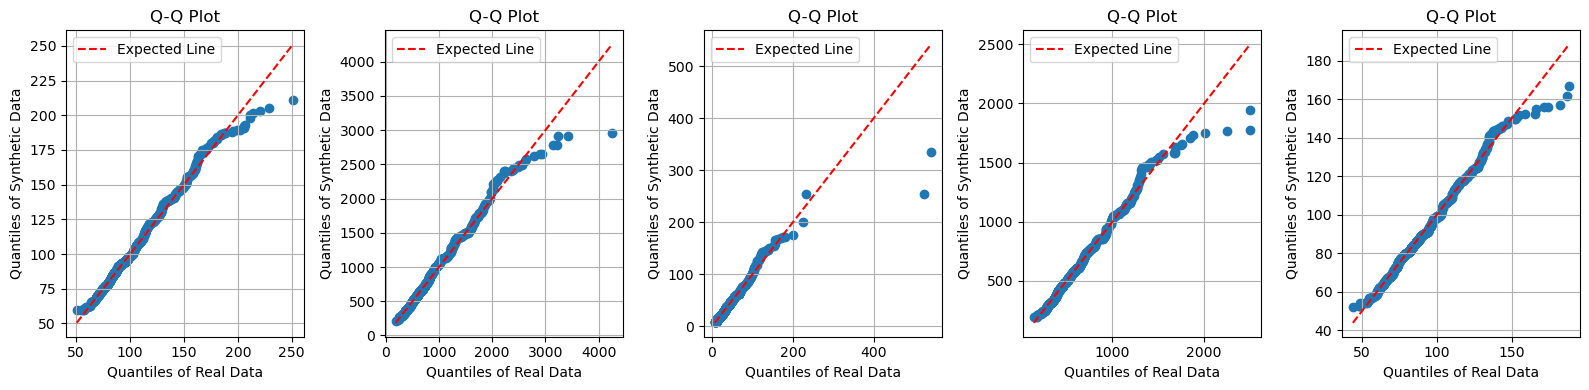

In [11]:
critic_features_target = critic_features + ['target']
utils.plot_quantiles(real_bc[critic_features], fake_df[critic_features])

All in all, the Q-Q plots seem to show adequate overlap. What about synthetic distributions?

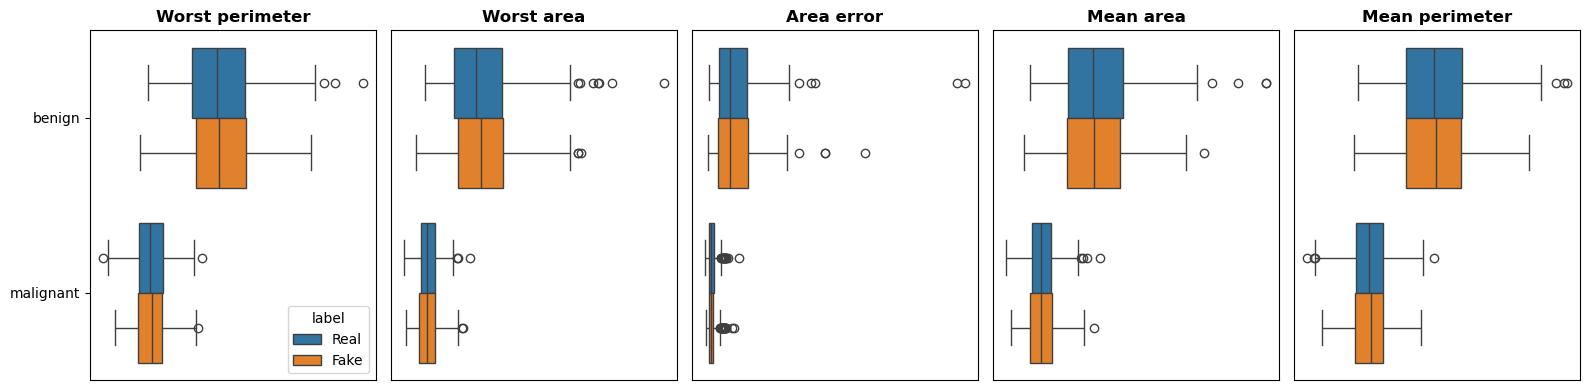

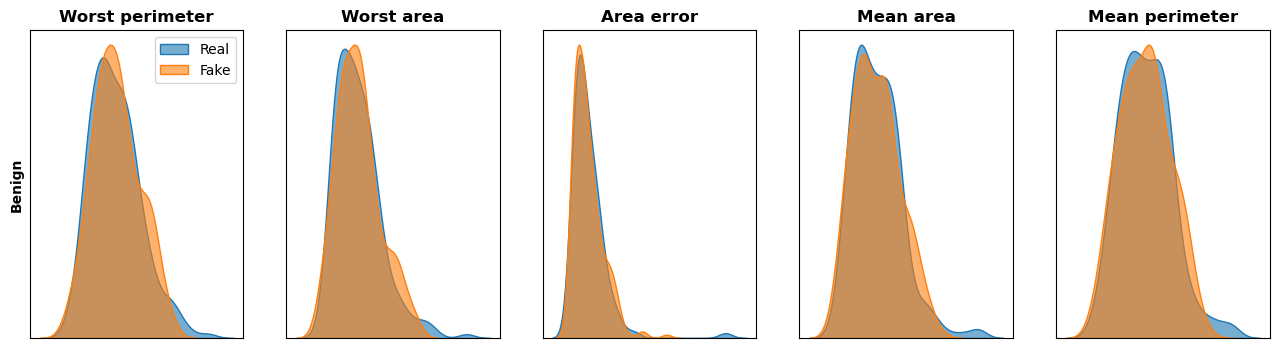

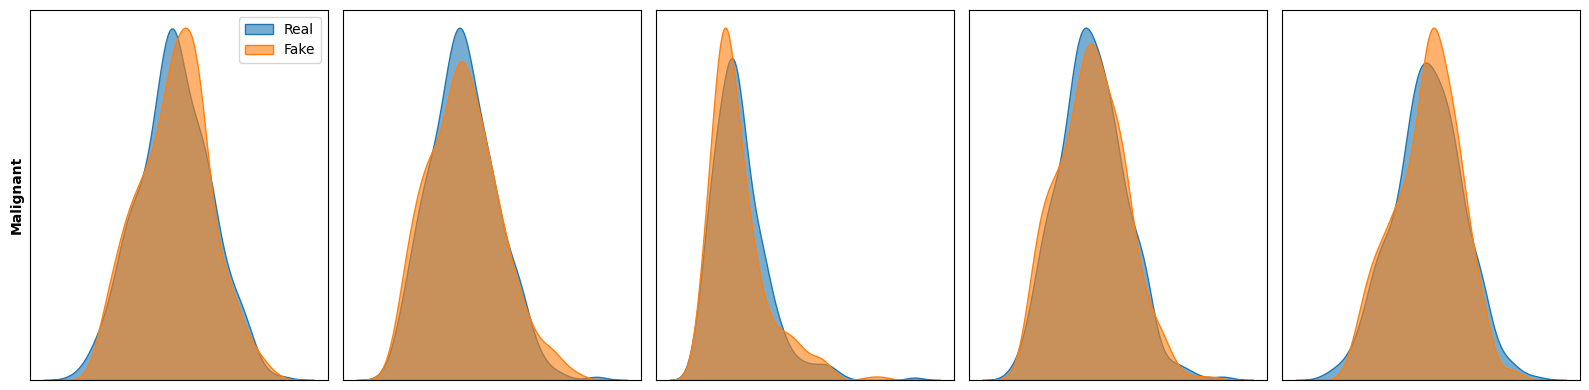

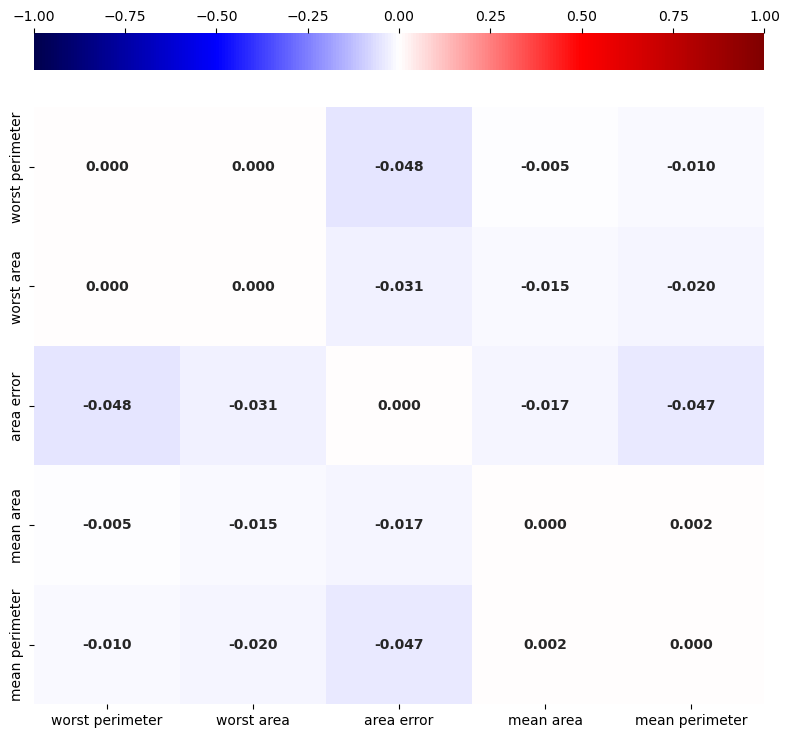

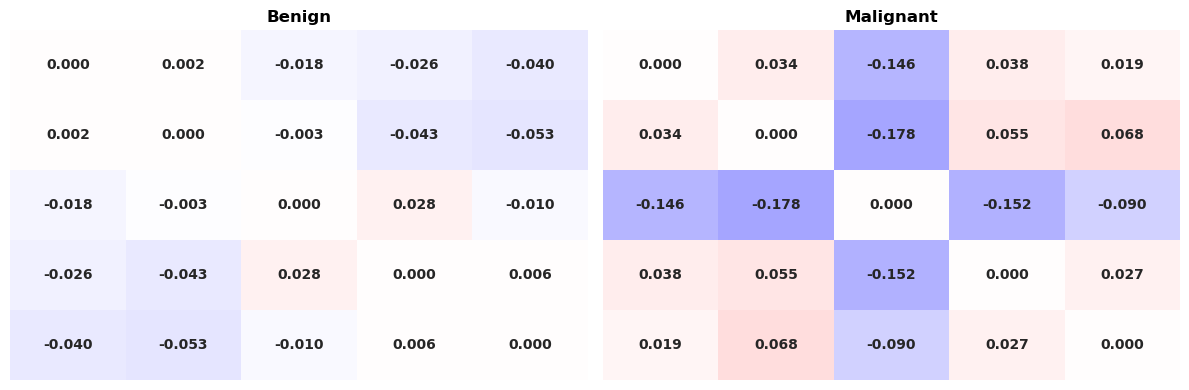

In [12]:
utils.plot_data(real_bc[critic_features_target], 'target', fake_df[critic_features_target])

In [13]:
random_datasets = []

total_fake_df = 1000

for seed in tqdm(range(1, total_fake_df + 1), desc = 'Generating Data'):
    utils.set_seed(seed)
    seed_z = torch.randn(real_bc.shape[0], noise_dim)
    random_df = pd.DataFrame(pd.DataFrame(min_max.inverse_transform(gen(seed_z, real_bc_dataloader.dataset.label).detach().numpy())))
    random_df['target'] = real_bc['target']
    random_df.columns = real_bc.columns
    random_df = random_df[real_bc.columns]
    random_datasets.append(random_df)

Generating Data:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
ks_statistic_list = []
wasserstein_distance_list =[]

for dataset in tqdm(random_datasets, desc = 'Evaluating Data'):
    ks_statistic_list.append(utils.calculate_ks_test(real_bc, dataset))
    wasserstein_distance_list.append(utils.calculate_wasserstein_distance(real_bc, dataset))

Evaluating Data:   0%|          | 0/1000 [00:00<?, ?it/s]

In 0 dataframes H0 is rejected for 0 features.
In 0 dataframes H0 is rejected for 1 features.
In 0 dataframes H0 is rejected for 2 features.
In 0 dataframes H0 is rejected for 3 features.
In 0 dataframes H0 is rejected for 4 features.
In 0 dataframes H0 is rejected for 5 features.
In 0 dataframes H0 is rejected for 6 features.
In 0 dataframes H0 is rejected for 7 features.
In 0 dataframes H0 is rejected for 8 features.
In 0 dataframes H0 is rejected for 9 features.
In 0 dataframes H0 is rejected for 10 features.
In 0 dataframes H0 is rejected for 11 features.
In 0 dataframes H0 is rejected for 12 features.
In 0 dataframes H0 is rejected for 13 features.
In 0 dataframes H0 is rejected for 14 features.
In 0 dataframes H0 is rejected for 15 features.
In 0 dataframes H0 is rejected for 16 features.
In 0 dataframes H0 is rejected for 17 features.
In 0 dataframes H0 is rejected for 18 features.
In 0 dataframes H0 is rejected for 19 features.
In 0 dataframes H0 is rejected for 20 features.
In

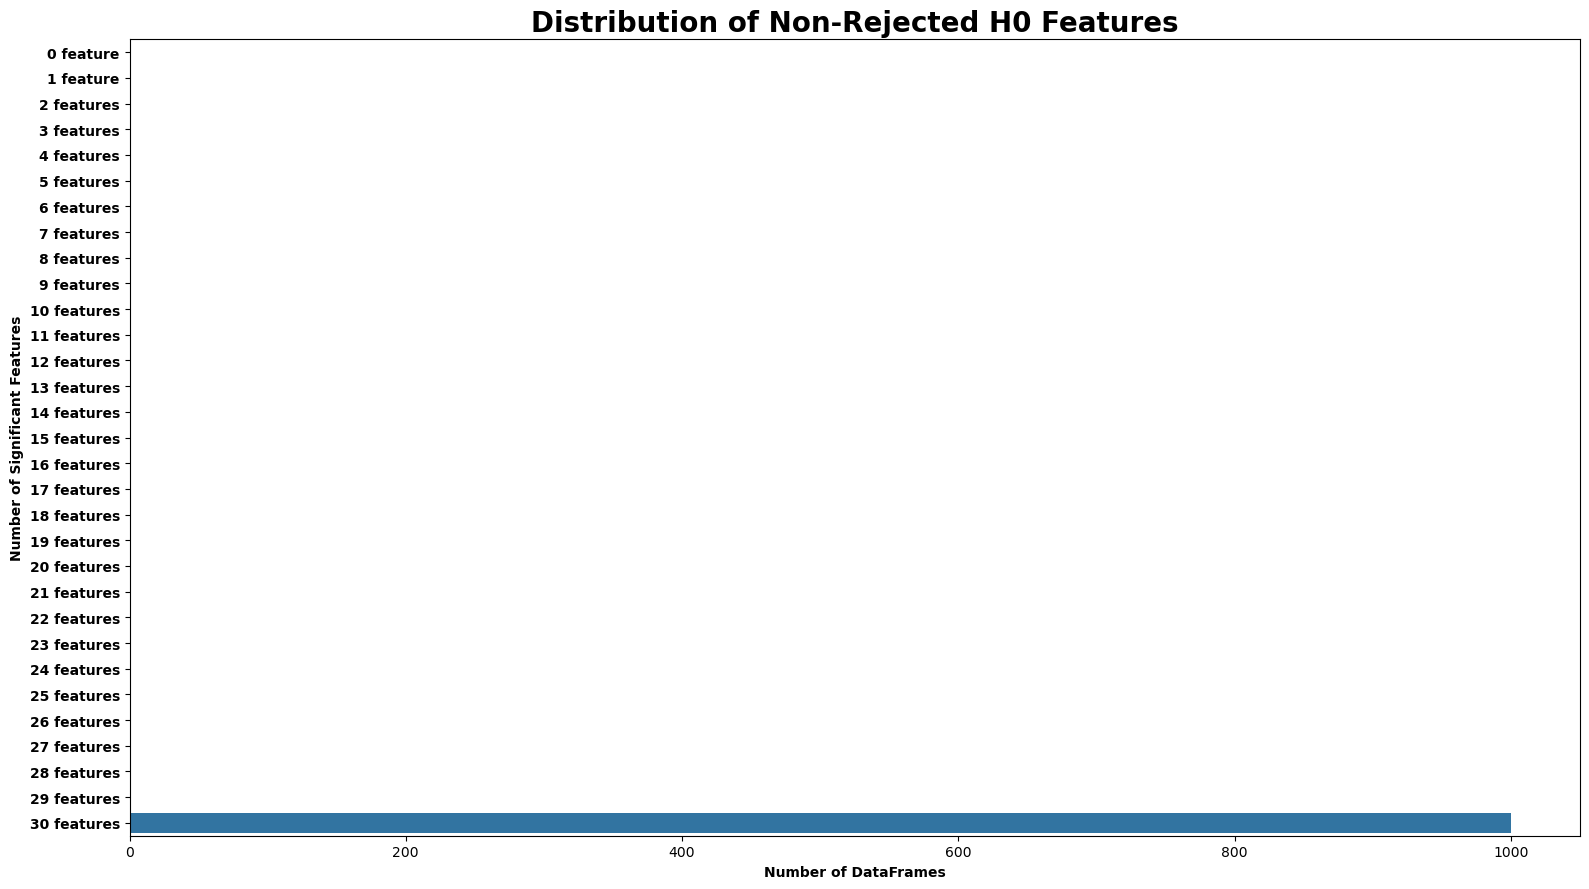

In [15]:
counts = {i: 0 for i in range(real_bc.shape[1])}

alpha = 0.05/total_fake_df

for df in ks_statistic_list:
    sign_feature = (df['P-Value'] >= alpha).sum()
    counts[sign_feature] += 1
    
for i in range(real_bc.shape[1]):
    print(f"In {counts[i]} dataframes H0 is rejected for {i} features.")

fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x=list(counts.values()), y=list(counts.keys()), orient='h')
ax.set_yticklabels([f"{i} feature{'s' if i > 1 else ''}" for i in range(real_bc.shape[1])], weight = 'bold')
plt.xlabel("Number of DataFrames", weight = 'bold')
plt.ylabel("Number of Significant Features", weight = 'bold')
plt.title("Distribution of Non-Rejected H0 Features", weight = 'bold', fontsize = 20)
plt.tight_layout();

0 feature too far from real in 0 datasets
1 feature too far from real in 0 datasets
2 feature too far from real in 0 datasets
3 feature too far from real in 0 datasets
4 feature too far from real in 25 datasets
5 feature too far from real in 974 datasets
6 feature too far from real in 1 datasets
7 feature too far from real in 0 datasets
8 feature too far from real in 0 datasets
9 feature too far from real in 0 datasets
10 feature too far from real in 0 datasets
11 feature too far from real in 0 datasets
12 feature too far from real in 0 datasets
13 feature too far from real in 0 datasets
14 feature too far from real in 0 datasets
15 feature too far from real in 0 datasets
16 feature too far from real in 0 datasets
17 feature too far from real in 0 datasets
18 feature too far from real in 0 datasets
19 feature too far from real in 0 datasets
20 feature too far from real in 0 datasets
21 feature too far from real in 0 datasets
22 feature too far from real in 0 datasets
23 feature too far

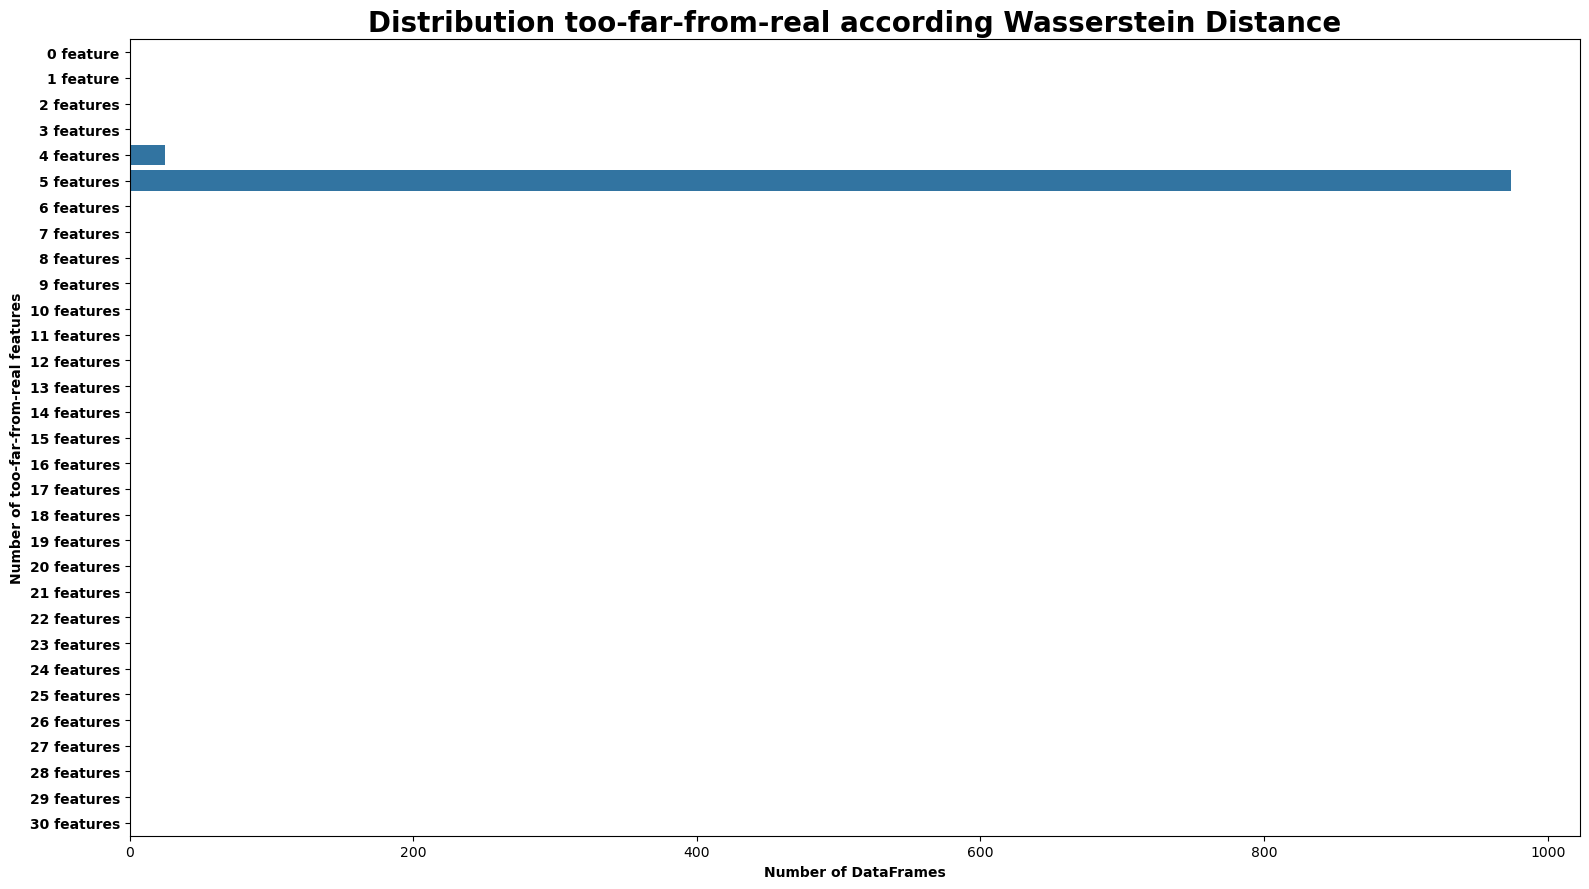

In [16]:
counts = {i: 0 for i in range(real_bc.shape[1])}

for df in wasserstein_distance_list:
    close_feature = (df['W Distance'] > 1).sum()
    counts[close_feature] += 1
    
for i in range(real_bc.shape[1]):
    print(f"{i} feature too far from real in {counts[i]} datasets")

fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x=list(counts.values()), y=list(counts.keys()), orient='h')
ax.set_yticklabels([f"{i} feature{'s' if i > 1 else ''}" for i in range(real_bc.shape[1])], weight = 'bold')
plt.xlabel("Number of DataFrames", weight = 'bold')
plt.ylabel("Number of too-far-from-real features", weight = 'bold')
plt.title("Distribution too-far-from-real according Wasserstein Distance", weight = 'bold', fontsize = 20)
plt.tight_layout();

In [17]:
ks_df = pd.concat(ks_statistic_list, ignore_index=True)
print(ks_df.groupby('Feature').mean().sort_values('KS Statistic'), ks_df.groupby('Feature').median().sort_values('KS Statistic'))

                         KS Statistic   P-Value
Feature                                        
mean perimeter               0.040005  0.736470
mean area                    0.040615  0.719714
worst radius                 0.042399  0.680596
worst concave points         0.042656  0.676348
smoothness error             0.042659  0.674501
concave points error         0.042805  0.670673
worst perimeter              0.043974  0.645877
worst smoothness             0.044293  0.634856
worst area                   0.044513  0.630960
mean radius                  0.045503  0.609809
texture error                0.045652  0.608621
mean texture                 0.046134  0.601897
worst texture                0.046327  0.598451
worst fractal dimension      0.047051  0.580206
mean concave points          0.047255  0.562455
mean compactness             0.047575  0.562882
fractal dimension error      0.047986  0.553214
mean concavity               0.048169  0.531122
mean smoothness              0.048422  0

In [18]:
wd_df = pd.concat(wasserstein_distance_list, ignore_index=True)
wd_df.groupby('Feature').mean().sort_values('W Distance'), wd_df.groupby('Feature').median().sort_values('W Distance')

(                         W Distance
 Feature                            
 fractal dimension error    0.000193
 smoothness error           0.000215
 concave points error       0.000512
 mean fractal dimension     0.000512
 symmetry error             0.000735
 mean smoothness            0.001002
 compactness error          0.001226
 worst fractal dimension    0.001258
 worst smoothness           0.001494
 concavity error            0.002277
 mean concave points        0.002613
 mean symmetry              0.002817
 mean compactness           0.003195
 worst concave points       0.003975
 mean concavity             0.004547
 worst symmetry             0.007044
 worst compactness          0.012906
 worst concavity            0.013980
 radius error               0.019948
 texture error              0.041711
 perimeter error            0.145879
 mean radius                0.243286
 worst radius               0.264279
 mean texture               0.333444
 worst texture              0.413201
 

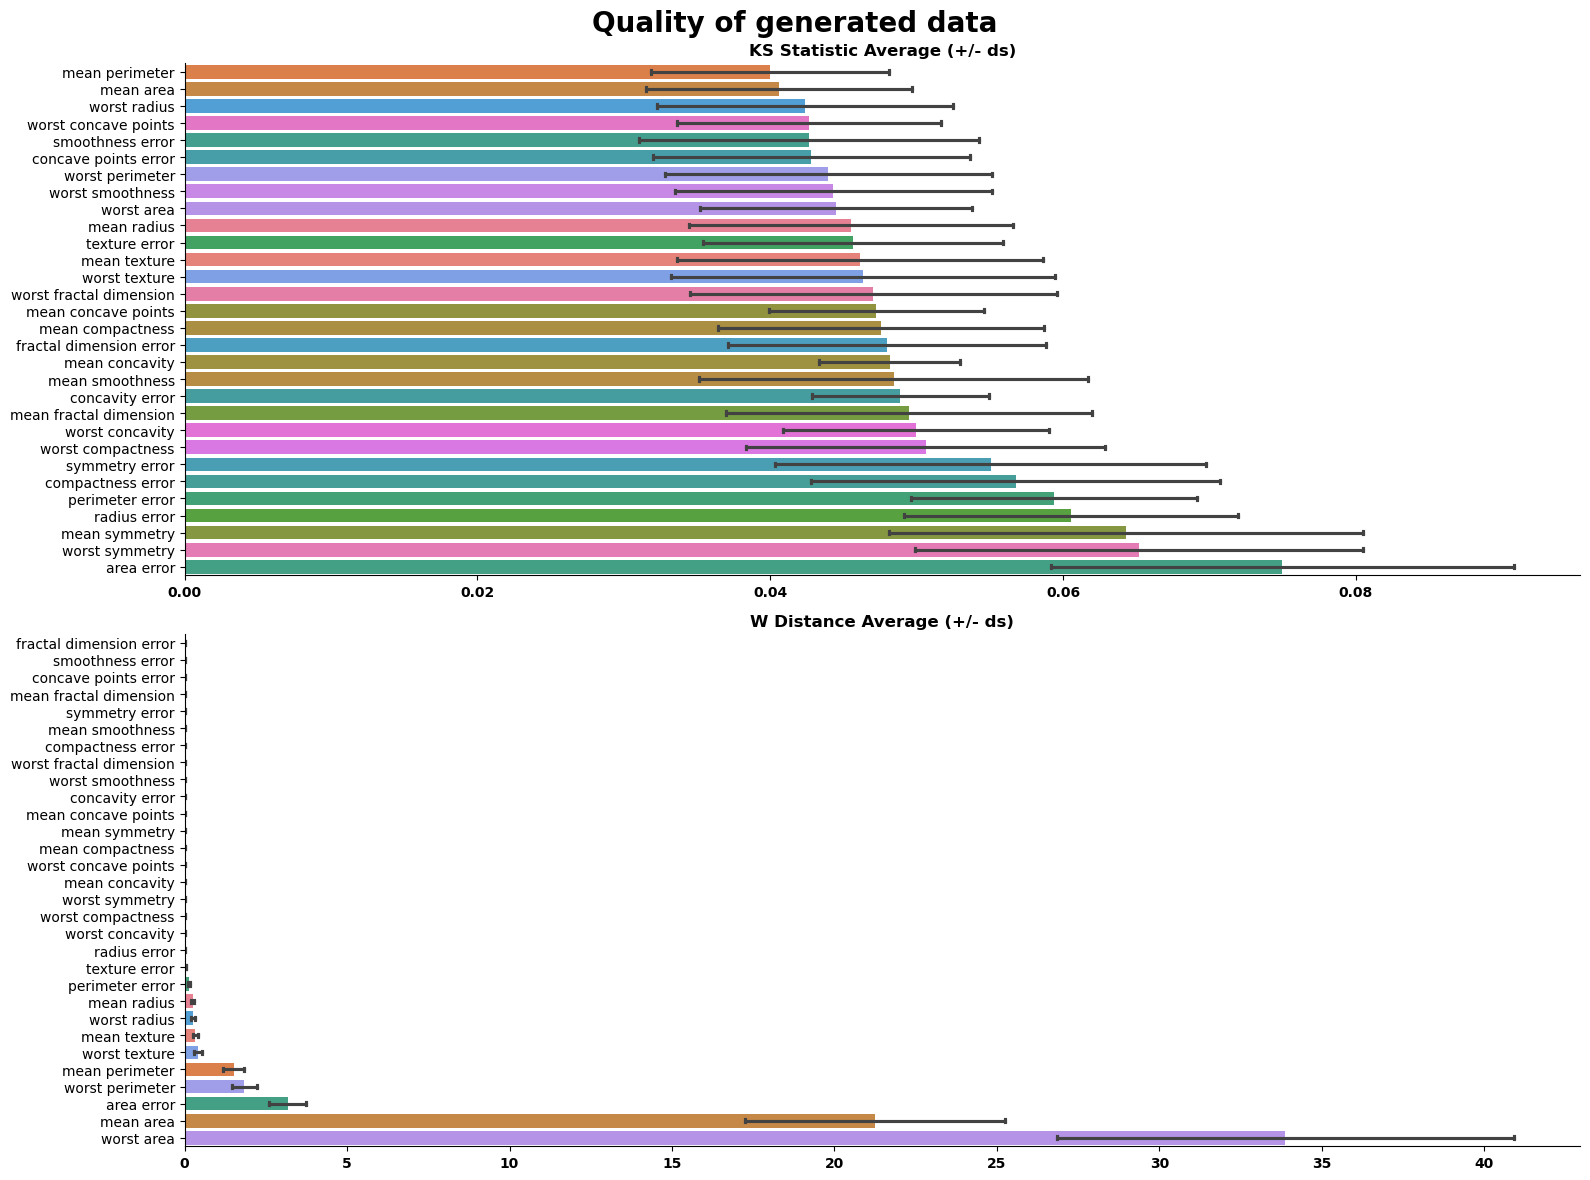

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (16, 12))

for idx, data in enumerate([ks_df.iloc[:, :2], wd_df]):
    
    sns.barplot(data, y = data.iloc[:,0], x = data.iloc[:,1], hue = 'Feature', errorbar = 'sd', capsize = 0.2,
                order = data.groupby('Feature').mean().sort_values(data.columns[1]).index, ax = ax[idx])
    
    ax[idx].set_ylabel('')
    ax[idx].set_xlabel('')
    ax[idx].set_title(data.columns[1] + ' Average (+/- ds)', weight = 'bold')
    ax[idx].set_xticklabels(ax[idx].get_xticklabels(), fontsize=10, weight='bold')
    
plt.suptitle('Quality of generated data', weight = 'bold', fontsize = 20)
sns.despine()
plt.tight_layout();

In [20]:
utils.set_seed(0)
z = torch.randn(real_bc.shape[0], noise_dim)

fake_bc = pd.DataFrame(min_max.inverse_transform(gen(z, real_bc_dataloader.dataset.label).detach().numpy()))
fake_bc['target'] = real_bc['target']
fake_bc.columns = real_bc.columns
fake_bc = fake_bc[real_bc.columns]

fake_bc.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,24.373644,23.008989,161.421997,1754.049927,0.103969,0.146226,0.209656,0.155713,0.151438,0.054148,...,25.273470,205.138535,2775.389893,0.139478,0.248195,0.496892,0.246378,0.239154,0.074645,benign
1,13.435938,22.654701,84.481758,525.046143,0.088596,0.079276,0.056594,0.028025,0.170579,0.057809,...,31.133846,103.394463,729.281677,0.129392,0.224510,0.318344,0.098377,0.323386,0.069329,benign
2,21.688665,21.065144,141.780029,1462.687744,0.105763,0.168071,0.202143,0.134598,0.186465,0.059053,...,28.260185,190.533707,2623.672607,0.152060,0.444473,0.496557,0.240941,0.308804,0.091364,benign
3,19.047071,20.481071,124.108658,1089.046631,0.087793,0.106122,0.104356,0.080722,0.197027,0.054710,...,23.362310,146.072617,1541.171143,0.109831,0.205367,0.270371,0.178145,0.321637,0.065491,benign
4,17.410683,23.150337,113.362740,853.019409,0.101180,0.089286,0.144607,0.072644,0.140221,0.054779,...,35.955853,145.290802,1351.757690,0.163550,0.187018,0.371300,0.193178,0.254853,0.071484,benign


In [53]:
X_real, y_real = real_bc.select_dtypes('number'), y

X_fake, y_fake = fake_bc.select_dtypes('number'), y

X_real_train, X_real_, y_real_train, y_real_ = train_test_split(X_real, y_real, test_size = 0.2, 
                                                                stratify = y_real, random_state = 0)
X_real_val, X_real_test, y_real_val, y_real_test = train_test_split(X_real_, y_real_, test_size = 0.5, 
                                                                    stratify = y_real_, random_state = 0)

X_fake_train, X_fake_, y_fake_train, y_fake_ = train_test_split(X_fake, y_fake, test_size = 0.2, 
                                                                stratify = y_fake, random_state = 0)
X_fake_val, X_fake_test, y_fake_val, y_fake_test = train_test_split(X_fake_, y_fake_, test_size = 0.5, 
                                                                    stratify = y_fake_, random_state = 0)

real_train_dict = {'Train Set': X_real_train, 'Val Set': X_real_val, 'Test Set': X_real_test}
fake_train_dict = {'Train Set': X_fake_train, 'Val Set': X_fake_val, 'Test Set': X_fake_test}

std_scaler = StandardScaler()

for dataset in [real_train_dict, fake_train_dict]:
    
    dataset['Train Set'] = std_scaler.fit_transform(dataset['Train Set'])
    dataset['Val Set'] = std_scaler.transform(dataset['Val Set'])
    dataset['Test Set'] = std_scaler.transform(dataset['Test Set'])
    
X_real_train, X_real_val, X_real_test = real_train_dict['Train Set'], real_train_dict['Val Set'], real_train_dict['Test Set']
X_fake_train, X_fake_val, X_fake_test = fake_train_dict['Train Set'], fake_train_dict['Val Set'], fake_train_dict['Test Set']

print(f'Train instances: {X_real_train.shape[0]}')
print(f'Val instances: {X_real_val.shape[0]}')
print(f'Test instances: {X_real_test.shape[0]}')

Train instances: 455
Val instances: 57
Test instances: 57


In [86]:
BS = 128

real_train_dataset = BreastCancer(X_real_train, y_real_train)
real_val_dataset = BreastCancer(X_real_val, y_real_val)
real_test_dataset = BreastCancer(X_real_test, y_real_test)

real_train_dataloader = DataLoader(real_train_dataset, batch_size = BS, shuffle = True)

fake_train_dataset = BreastCancer(X_fake_train, y_fake_train)
fake_val_dataset = BreastCancer(X_fake_val, y_fake_val)
fake_test_dataset = BreastCancer(X_fake_test, y_fake_test)

fake_train_dataloader = DataLoader(fake_train_dataset, batch_size = BS, shuffle = True)

In [87]:
data_dim = real_bc.select_dtypes('number').shape[1]
target_dim = real_bc['target'].nunique()

class Classifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.Classifier = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        x = self.Classifier(x)
        return x    

utils.set_seed()
TOR_clf = Classifier(input_dim = data_dim, output_dim = target_dim)
TOS_clf = Classifier(input_dim = data_dim, output_dim = target_dim)

print(f'Classifier has {sum(p.numel() for p in TOR_clf.parameters())} parameters.')

Classifier has 12354 parameters.


In [88]:
clf_lr = 1e-5

TOR_opt = torch.optim.AdamW(TOR_clf.parameters(), lr = clf_lr)
TOS_opt = torch.optim.AdamW(TOS_clf.parameters(), lr = clf_lr)

criterion = nn.CrossEntropyLoss()

TOR_dict = {'Model': TOR_clf, 'Dataloader': real_train_dataloader, 'Validation': real_val_dataset, 
            'Optimizer': TOR_opt, 'Train Loss': [], 'Val Loss':[], 'Label':'Real'}

TOS_dict = {'Model': TOS_clf, 'Dataloader': fake_train_dataloader, 'Validation': fake_val_dataset, 
            'Optimizer': TOS_opt, 'Train Loss': [], 'Val Loss':[], 'Label':'Synthetic'}

In [89]:
epochs = 1000
verbose = 0.1

for clf in [TOR_dict, TOS_dict]:
    for epoch in tqdm(range(epochs + 1), desc = f"Training on {clf['Label']} Data"):
        
        clf['Model'].train()
        
        epoch_loss = 0
        
        for batch, (data, label) in enumerate(clf['Dataloader']):
            
            clf['Optimizer'].zero_grad()
            
            y_pred_logits = clf['Model'](data)
            loss = criterion(y_pred_logits, label)
            epoch_loss += loss.item()
            
            loss.backward()
            clf['Optimizer'].step()
            
        with torch.no_grad():
            clf['Model'].eval()
            y_val_logits = clf['Model'](clf['Validation'].data)
            clf['Val Loss'].append(criterion(y_val_logits, clf['Validation'].label).item())
            
        clf['Train Loss'].append(epoch_loss/len(clf['Dataloader']))
        
        if epoch % (epochs * verbose) == 0 or epoch == epochs:
            print(f"{epoch}/{epochs} | Train loss: {clf['Train Loss'][-1]:.4f} | Val loss: {clf['Val Loss'][-1]:.4f}")

Training on Real Data:   0%|          | 0/1001 [00:00<?, ?it/s]

0/1000 | Train loss: 0.6947 | Val loss: 0.6934
100/1000 | Train loss: 0.5287 | Val loss: 0.5486
200/1000 | Train loss: 0.3762 | Val loss: 0.4104
300/1000 | Train loss: 0.2687 | Val loss: 0.3052
400/1000 | Train loss: 0.1993 | Val loss: 0.2344
500/1000 | Train loss: 0.1481 | Val loss: 0.1876
600/1000 | Train loss: 0.1178 | Val loss: 0.1565
700/1000 | Train loss: 0.1072 | Val loss: 0.1359
800/1000 | Train loss: 0.0863 | Val loss: 0.1224
900/1000 | Train loss: 0.0805 | Val loss: 0.1142
1000/1000 | Train loss: 0.0691 | Val loss: 0.1096


Training on Synthetic Data:   0%|          | 0/1001 [00:00<?, ?it/s]

0/1000 | Train loss: 0.6858 | Val loss: 0.6895
100/1000 | Train loss: 0.5251 | Val loss: 0.5330
200/1000 | Train loss: 0.3793 | Val loss: 0.3888
300/1000 | Train loss: 0.2637 | Val loss: 0.2771
400/1000 | Train loss: 0.1861 | Val loss: 0.2038
500/1000 | Train loss: 0.1381 | Val loss: 0.1573
600/1000 | Train loss: 0.1080 | Val loss: 0.1265
700/1000 | Train loss: 0.0906 | Val loss: 0.1054
800/1000 | Train loss: 0.0696 | Val loss: 0.0900
900/1000 | Train loss: 0.0627 | Val loss: 0.0786
1000/1000 | Train loss: 0.0519 | Val loss: 0.0701


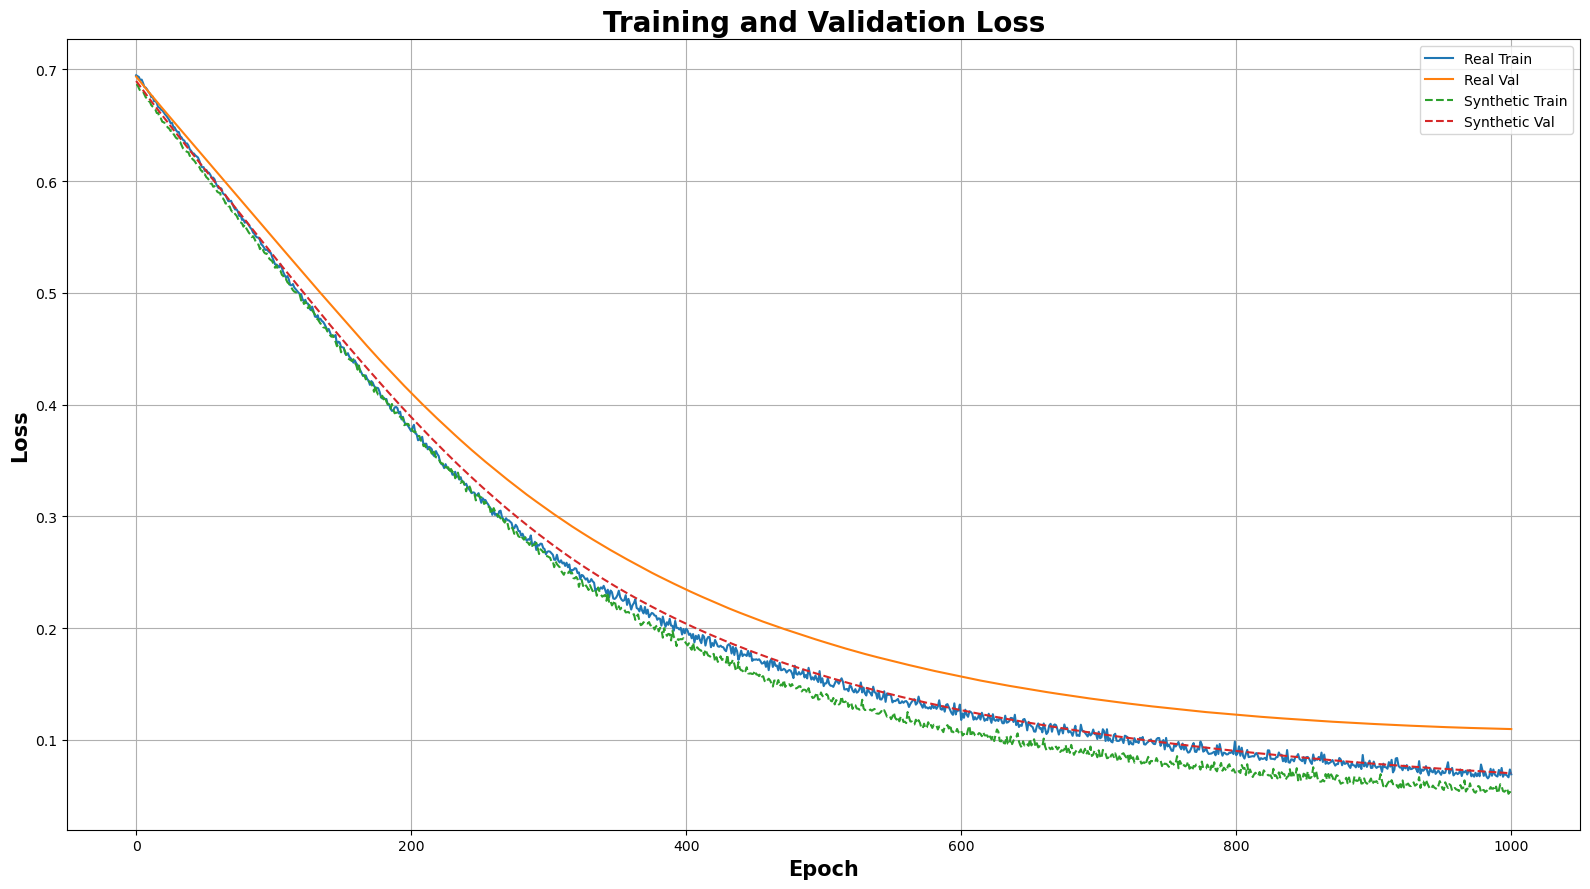

In [90]:
plt.figure(figsize = (16, 9))
for model in [TOR_dict, TOS_dict]:
    if model['Label'] == 'Synthetic':
        line = '--'
    else:
        line = '-'

    plt.plot(model['Train Loss'], label = f"{model['Label']} Train", linestyle = line)
    plt.plot(model['Val Loss'], label = f"{model['Label']} Val", linestyle = line)

plt.title('Training and Validation Loss', weight = 'bold', size = 20)
plt.xlabel('Epoch', weight = 'bold', size = 15)
plt.ylabel('Loss', weight = 'bold', size = 15)
plt.legend()
plt.legend()
plt.grid(True)
plt.tight_layout();

In [91]:
accuracy = torchmetrics.Accuracy(task = "binary", num_classes = target_dim)
precision = torchmetrics.Precision(task = "binary", num_classes = target_dim)
recall = torchmetrics.Recall(task = "binary", num_classes = target_dim)
f1 = torchmetrics.F1Score(task = "binary", num_classes = target_dim)

tor_metrics_list = []
tos_metrics_list = []

with torch.no_grad():
    TOR_dict['Model'].eval()
    y_test_pred = TOR_dict['Model'](real_test_dataset.data)
    y_test_pred_labels = torch.argmax(y_test_pred, dim = 1)

    for metric in [accuracy, precision, recall, f1]:
        metric.reset()
        tor_metrics_list.append(metric(y_test_pred_labels, real_test_dataset.label).item())

with torch.no_grad():
    TOS_dict['Model'].eval()
    y_test_pred = TOS_dict['Model'](fake_test_dataset.data)
    y_test_pred_labels = torch.argmax(y_test_pred, dim = 1)

    for metric in [accuracy, precision, recall, f1]:
        metric.reset()
        tos_metrics_list.append(metric(y_test_pred_labels, fake_test_dataset.label).item())

print(f'Real | Accuracy: {tor_metrics_list[0]:.4%} | Precision: {tor_metrics_list[1]:.4%} | Recall: {tor_metrics_list[2]:.4%} | F1: {tor_metrics_list[3]:.4%}')
print(f'Fake | Accuracy: {tos_metrics_list[0]:.4%} | Precision: {tos_metrics_list[1]:.4%} | Recall: {tos_metrics_list[2]:.4%} | F1: {tos_metrics_list[3]:.4%}')

Real | Accuracy: 96.4912% | Precision: 97.2222% | Recall: 97.2222% | F1: 97.2222%
Fake | Accuracy: 98.2456% | Precision: 97.2973% | Recall: 100.0000% | F1: 98.6301%


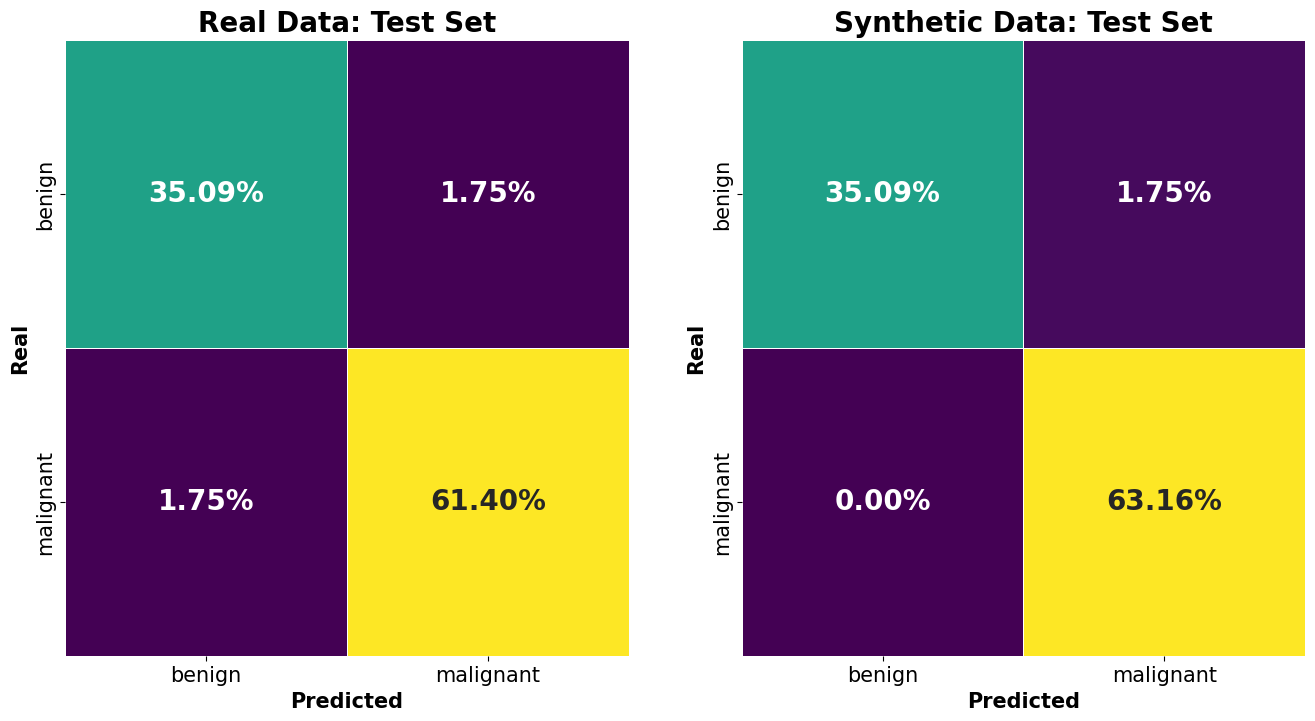

In [104]:
with torch.no_grad():
    TOR_dict['Model'].eval()
    y_test_pred = TOR_dict['Model'](real_test_dataset.data)
    y_test_pred_labels = torch.argmax(y_test_pred, dim = 1)
    
    real_test_confusion_matrix = confusion_matrix(real_test_dataset.label, y_test_pred_labels, normalize = 'all')
    
with torch.no_grad():
    TOS_dict['Model'].eval()
    y_test_pred = TOR_dict['Model'](fake_test_dataset.data)
    y_test_pred_labels = torch.argmax(y_test_pred, dim = 1)
    
    fake_test_confusion_matrix = confusion_matrix(fake_test_dataset.label, y_test_pred_labels, normalize = 'all')
    
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
for idx, data in enumerate([real_test_confusion_matrix, fake_test_confusion_matrix]):
    sns.heatmap(data = data, ax = ax[idx], cbar = False, cmap = 'viridis', annot = True, robust = True, 
                annot_kws = {'weight':'bold', 'size':20}, xticklabels = classes, yticklabels = classes, 
                linewidth = 0.5, fmt = '.2%')
    ax[idx].set_xlabel('Predicted', weight = 'bold', size = 15)
    ax[idx].set_ylabel('Real', weight = 'bold', size = 15)
    ax[idx].tick_params(axis='x', labelsize=15)
    ax[idx].tick_params(axis='y', labelsize=15)
    
    if idx == 0:
        title = 'Real Data: Test Set'
    else:
        title = 'Synthetic Data: Test Set'
        
    ax[idx].set_title(title, size = 20, weight = 'bold')
    

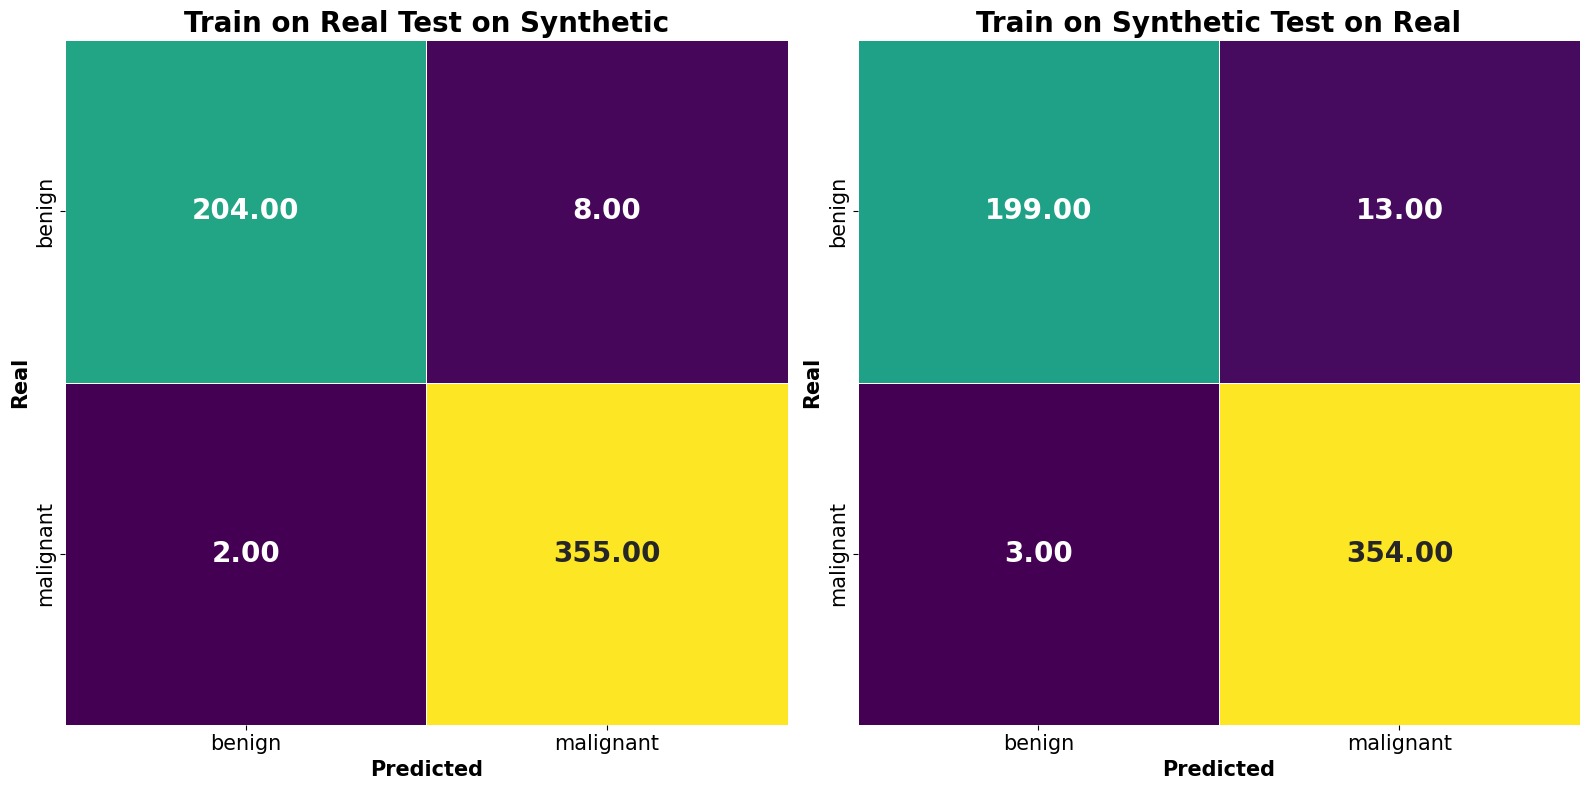

In [107]:
full_real_scaled = np.vstack([X_real_train, X_real_val, X_real_test])
full_fake_scaled = np.vstack([X_fake_train, X_fake_val, X_fake_test])

full_target = np.hstack([y_real_train, y_real_val, y_real_test])

full_real_bc_dataset = BreastCancer(full_real_scaled, full_target)
full_fake_bc_dataset = BreastCancer(full_fake_scaled, full_target)

TOR_dict['Model'].eval()
TOR_test_on_fake = TOR_dict['Model'](full_fake_bc_dataset.data)
TOR_test_on_fake_labels = torch.argmax(TOR_test_on_fake, dim = 1)
    
TOS_dict['Model'].eval()
TOS_test_on_real = TOS_dict['Model'](full_real_bc_dataset.data)
TOS_test_on_real_labels = torch.argmax(TOS_test_on_real, dim = 1)

trained_real_test_fake_cf = confusion_matrix(full_fake_bc_dataset.label, TOR_test_on_fake_labels)#, normalize = 'all')
trained_fake_test_real_cf = confusion_matrix(full_real_bc_dataset.label, TOS_test_on_real_labels)#, normalize = 'all')

fig, ax = plt.subplots(1, 2, figsize = (16, 8))
    
for idx, data in enumerate([trained_real_test_fake_cf, trained_fake_test_real_cf]):
    sns.heatmap(data = data, ax = ax[idx], cbar = False, cmap = 'viridis', annot = True, robust = True, 
                annot_kws = {'weight':'bold', 'size':20}, xticklabels = classes, yticklabels = classes, 
                linewidth = 0.5, fmt = '.2f')
    ax[idx].set_xlabel('Predicted', weight = 'bold', size = 15)
    ax[idx].set_ylabel('Real', weight = 'bold', size = 15)
    ax[idx].tick_params(axis='x', labelsize=15)
    ax[idx].tick_params(axis='y', labelsize=15)
    
    if idx == 0:
        title = 'Train on Real Test on Synthetic'
    else:
        title = 'Train on Synthetic Test on Real'
        
    ax[idx].set_title(title, size = 20, weight = 'bold')
    
plt.tight_layout();

The analysis conducted so far has shown that although for four features the Wasserstein distance exceeds the threshold of 1, their graphical overlap with the actual data appears satisfactory. In addition, comparison of the correlation matrices, both overall and broken down by class, shows a mean absolute difference of less than 0.1, suggesting that the relational structure between the variables has been preserved in the synthetic data.

However, these results are based on single feature level analyses and linear correlations. To gain a deeper understanding of the latent structure of the data and to check whether the synthetic data retain the same principal components as the real data, the next step will be the application of **Principal Component Analysis (PCA)**. This will allow us to:
- Identify the dimensions along which the real and synthetic data vary the most.
- Assess whether the principal components of the synthetic data reflect those of the original data.
- Visually analyze the distribution in the first principal axes to check the preservation of the overall structure of the data.

This analysis will help us further validate the quality of the synthetic data and identify any structural discrepancies that may not be apparent from single feature analyses alone.

## Principal Component Analysis

We will use **Principal Component Analysis (PCA)** to reduce the dimensionality of the data and identify underlying latent structures. PCA creates new variables, called principal components, which are linear combinations of the original variables and capture most of the variance in the data. This will allow us to compare the distribution and structure of the synthetic data against the real data, checking whether they preserve the same relationships between features. Specifically:

- **Numeric Analysis:**
    - Comparison of variance explained by principal components
    - Distance between principal components via cosine distance
    - Similarity in PCA coordinate distribution using Wasserstein distance
    
- **Graphic Analysis:**
    - Screeplot
    - Scatterplot of the first major components
    
This entire phase will be conducted on the first **5 components**.

In [94]:
from sklearn.decomposition import PCA

components = 5

pca_real = PCA(n_components = components)
pca_fake = PCA(n_components = components)

real_data_pca = pca_real.fit_transform(real_bc.select_dtypes('number'))
fake_data_pca = pca_fake.fit_transform(fake_df.select_dtypes('number'))

### Explained Variance

In [95]:
data_label = ['Real', 'Fake']

real_ev_ratio = pca_real.explained_variance_ratio_
fake_ev_ratio = pca_fake.explained_variance_ratio_

pd.DataFrame(np.vstack([real_ev_ratio, fake_ev_ratio]), 
             columns = [f'Component {component + 1}' for component in range(components)], 
             index = data_label).style.background_gradient(cmap = 'viridis', axis = 1)

,Component 1,Component 2,Component 3,Component 4,Component 5
Real,0.982045,0.016176,0.001558,0.000121,0.000088
Fake,0.988461,0.010266,0.001033,0.000139,0.000085


PCA analysis shows that the distribution of variance among the principal components is very similar in the real and synthetic data. In both datasets, the first principal component captures almost all of the variance **(98.2% in the reals, 99.0% in the synthetics)**, indicating that the dominant latent structure was well reproduced. However, the lower variance explained by the later components in the synthetic data suggests possible rigidity in generation, with a slight loss of detail in the secondary variances. We move on to examine the alignment between components using cosine distance.

### Cosine Distance

In [96]:
from scipy.spatial.distance import cosine

for idx, component in enumerate(range(components)):
    print(f"Cosine distance for component {idx + 1}: {cosine(pca_real.components_[component], pca_fake.components_[component]):.4f}")

Cosine distance for component 1: 0.0000
Cosine distance for component 2: 0.0014
Cosine distance for component 3: 0.0030
Cosine distance for component 4: 1.9169
Cosine distance for component 5: 1.9158


The first three components have a cosine distance very close to zero, indicating high similarity between the principal directions of variance in the real and synthetic data. This suggests that the generative model captured the dominant latent structures in the data well.
The fourth component shows a slightly higher distance **(0.1556)**, signaling less alignment with actual data, but not critical.
The fifth component has a very high distance **(1.8422)**, which suggests that this direction of variance is very different between the two datasets. **However, since the first components explain almost all of the variance (>99%), this discrepancy may have a negligible impact.**

### Wasserstein Distance

In [97]:
real_pca_df = pd.DataFrame(real_data_pca, columns = [f'Component {component + 1}' for component in range(components)])
fake_pca_df = pd.DataFrame(fake_data_pca, columns = [f'Component {component + 1}' for component in range(components)])

utils.calculate_wasserstein_distance(real_pca_df, fake_pca_df).style.background_gradient(cmap = 'Reds')

,Feature,W Distance
0,Component 1,32.820493
1,Component 2,11.228073
2,Component 3,2.186431
3,Component 4,1.289068
4,Component 5,0.856708


Wasserstein distances show a significant discrepancy in the first two components, indicating that the generative model does not perfectly capture the main structure of the data. However, the later components show more overlap, suggesting that less dominant features are more faithfully reproduced.

### Screeplot

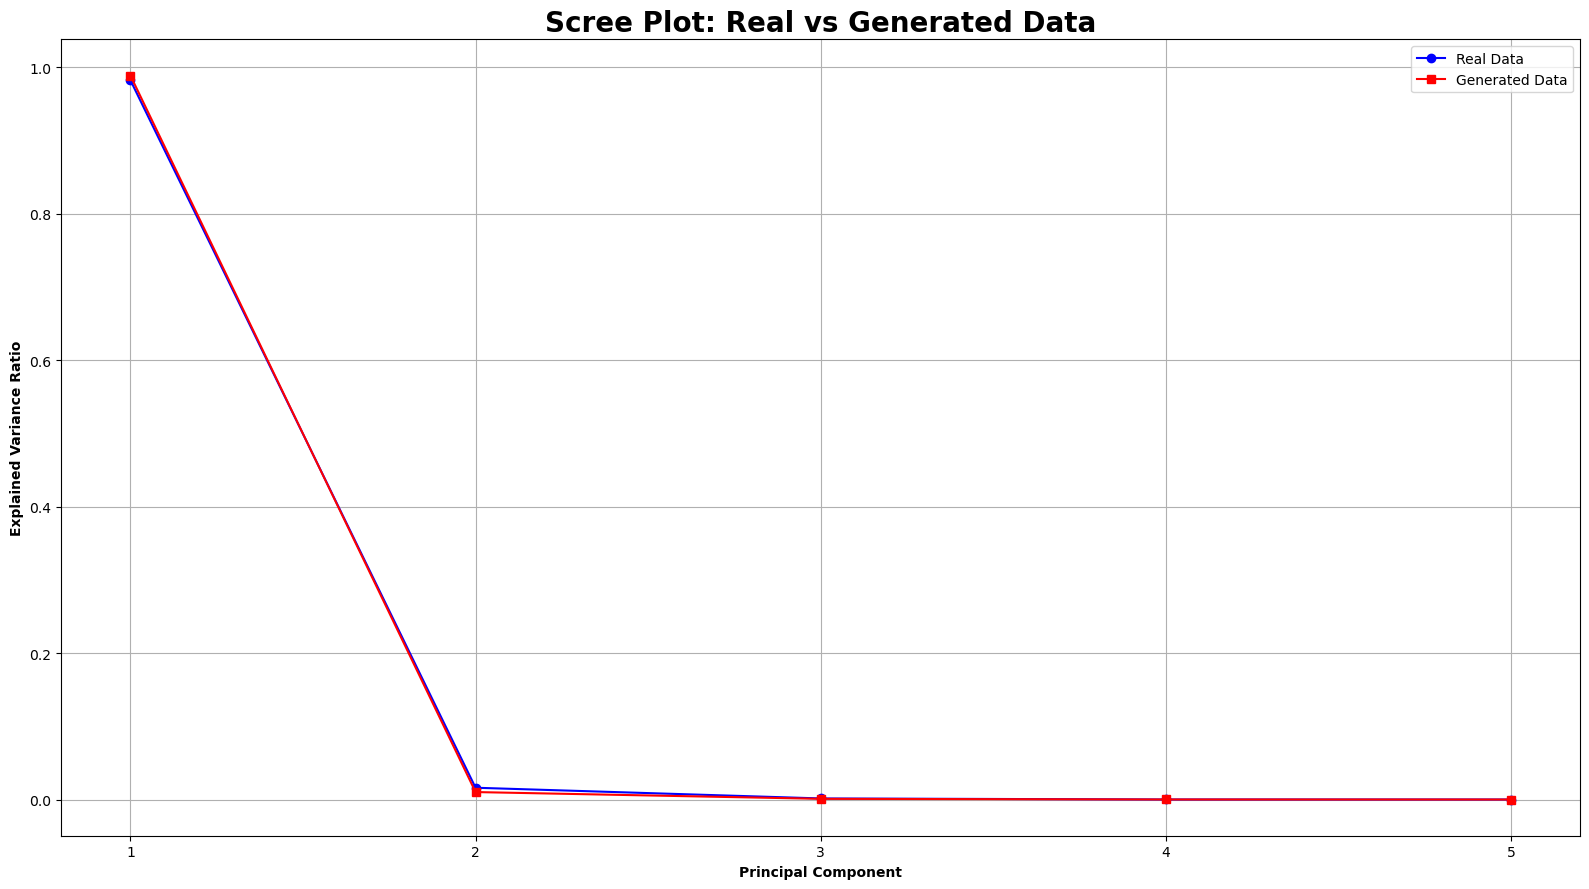

In [98]:
plt.figure(figsize = (16, 9))

plt.plot(np.arange(1, components + 1), pca_real.explained_variance_ratio_, 'o-', label = "Real Data", color = 'blue')
plt.plot(np.arange(1, components + 1), pca_fake.explained_variance_ratio_, 's-', label = "Generated Data", color = 'red')

plt.xlabel("Principal Component", weight = 'bold')
plt.ylabel("Explained Variance Ratio", weight = 'bold')
plt.title("Scree Plot: Real vs Generated Data", weight = 'bold', fontsize = 20)
plt.xticks(np.arange(1, components + 1))
plt.legend()
plt.grid(True)
plt.tight_layout();

The graph compares the variance explained by the principal components in the real and generated data. The superimposed curves indicate that the variance structure in the synthetic data is very similar to that in the real data, suggesting that the generative model captured latent relationships well. However, for further evaluation, it is useful to supplement this analysis with other similarity metrics.

### Scatterplot of components

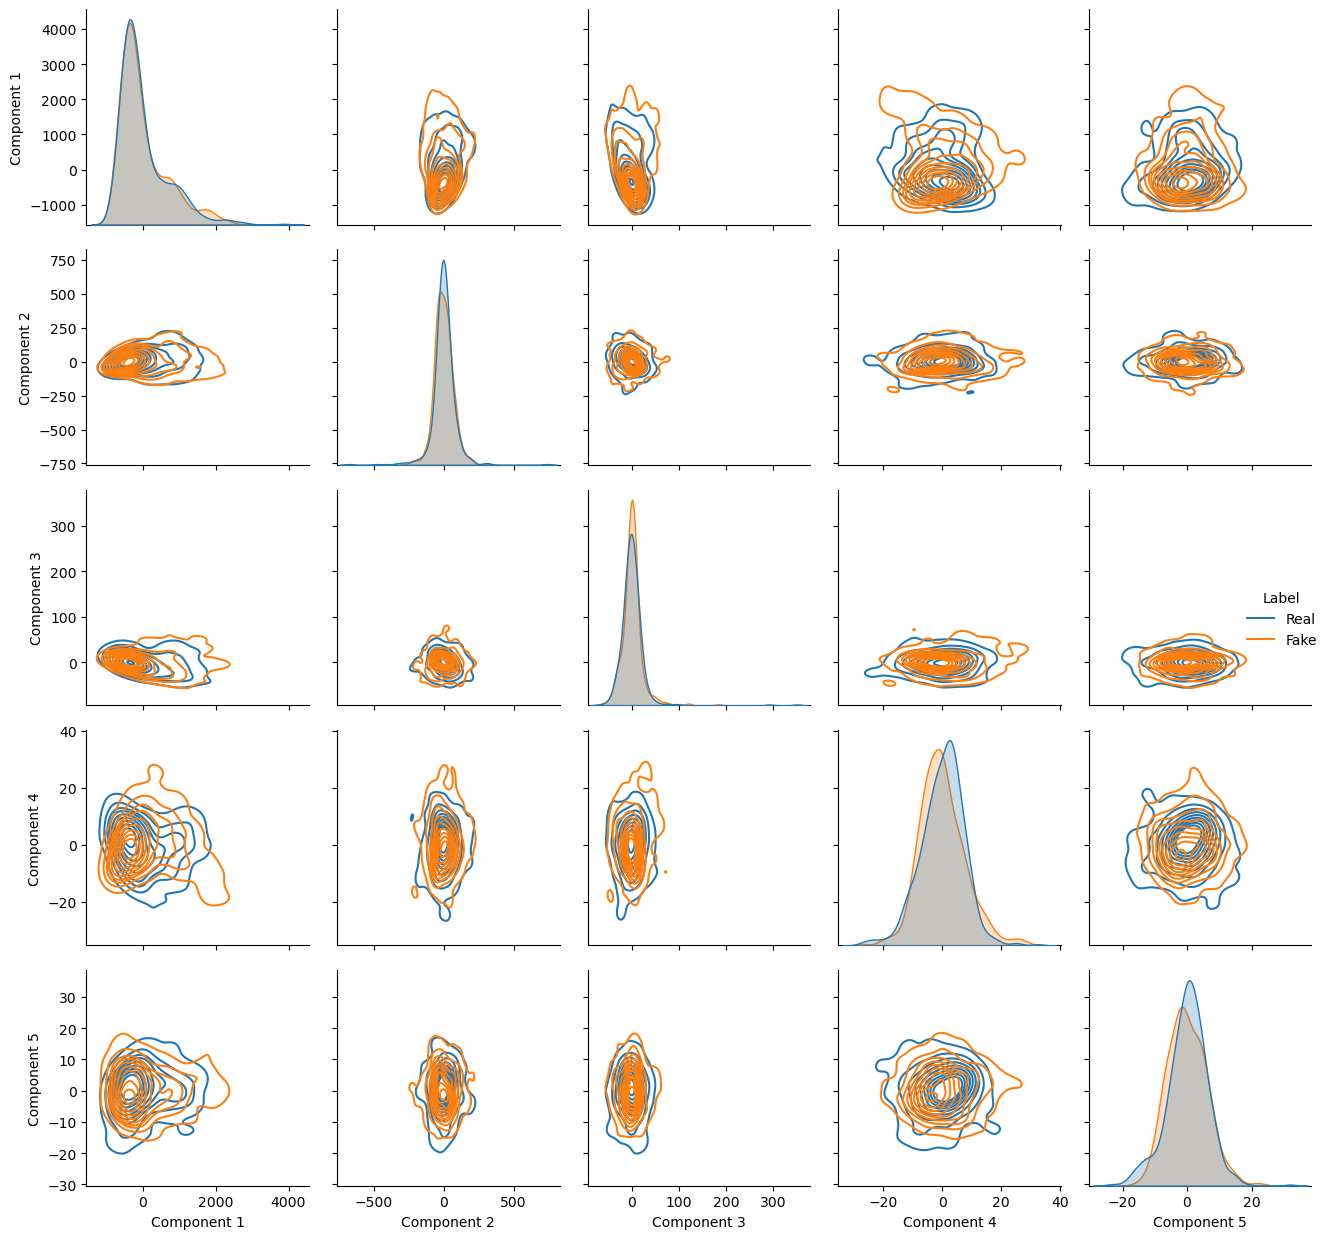

In [99]:
real_pca_df['Label'] = 'Real'
fake_pca_df['Label'] = 'Fake'

full_pca_df = pd.concat([real_pca_df, fake_pca_df], ignore_index = True)

sns.pairplot(full_pca_df, hue = 'Label', kind = 'kde')
plt.tight_layout();

Examining the numerical and graphical results of the analyses conducted on the PCA we see that overall the components appear to be similar, indicating that the model adequately captured variance and latent relationships in the data. We will have the final proof by training two classifiers, each on one of the two datasets and doing the cross-comparison.